## Дипломный проект на курсе Data Science школа SkillFactory
# «Модель прогнозирования стоимости жилья для агентства недвижимости»

**Цель:** разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок.

**Поставленные задачи:**
1. Провести разведывательный анализ и очистку исходных данных. Обратите внимание, что данные в таблице реальные: в результате во многих признаках присутствуют дублирующиеся категории, ошибки ввода, жаргонные сокращения и т .д. Вам предстоит отыскать закономерности, самостоятельно расшифровать все сокращения, найти синонимы в данных, обработать пропуски и удалить выбросы. 
2. Выделить наиболее значимые факторы, влияющие на стоимость недвижимости.
3. Построить модель для прогнозирования стоимости недвижимости.
4. Разработать небольшой веб-сервис, на вход которому поступают данные о некоторой выставленной на продажу недвижимости, а сервис прогнозирует его стоимость.

**Описание данных:**<br>
<br>
➔ 'status' — статус продажи;<br>
➔ 'private pool' и 'PrivatePool' — наличие собственного бассейна;<br>
➔ 'propertyType' — тип объекта недвижимости;<br>
➔ 'street' — адрес объекта;<br>
➔ 'baths' — количество ванных комнат;<br>
➔ 'homeFacts' — сведения о строительстве объекта (содержит несколько
типов сведений, влияющих на оценку объекта);<br>
➔ 'fireplace' — наличие камина;<br>
➔ 'city' — город;<br>
➔ 'schools' — сведения о школах в районе;<br>
➔ 'sqft' — площадь в футах;<br>
➔ 'zipcode' — почтовый индекс;<br>
➔ 'beds' — количество спален;<br>
➔ 'state' — штат;<br>
➔ 'stories' — количество этажей;<br>
➔ 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система
мультилистинга);<br><br>

➔ **'target'** — цена объекта недвижимости (целевой признак, который
необходимо спрогнозировать).

In [902]:
import numpy as np 
import pandas as pd

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import os

# внешняя функция для поиска выбросов
from outliers_lib.find_outliers import find_outliers_iqr

# для графиков
import seaborn as sns
import plotly.subplots as spimport
import matplotlib.pyplot as plt

# для нормализации
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

# импорт для работы с кодировщиком
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [903]:
# зафиусируем RANDOM_SEED
RANDOM_SEED = 42

In [904]:
# зафиксируем версию пакетов
!pip freeze > requirements.txt

## 2. Разведывательный анализ (EDA) и преобразование данных

In [905]:
df = pd.read_csv('data/cleaned_data.csv')
df.head()

,status,propertyType,street,baths,city,sqft,zipcode,state,target,private_pool_final,beds_final,schools_rating,school_distance_min,Year built,Remodeled year_final,Heating_final
0,Active,single family,240 Heather Ln,3.5,Southern Pines,2900,28387,NC,418000,False,4.0,5.200000,2.70,2019,False,True
1,For sale,single family,12911 E Heroy Ave,3.0,Spokane Valley,1947,99216,WA,310000,False,3.0,4.000000,1.01,2019,False,False
2,For sale,single family,2005 Westridge Rd,2.0,Los Angeles,3000,90049,CA,2895000,True,3.0,6.666667,1.19,1961,True,True
3,For sale,single family,4311 Livingston Ave,8.0,Dallas,6457,75205,TX,2395000,False,5.0,9.250000,0.10,2006,True,True
4,For sale,land,1524 Kiscoe St,0.0,Palm Bay,0,32908,FL,5000,False,0.0,4.666667,3.03,unknown,False,False


In [906]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374249 entries, 0 to 374248
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                374249 non-null  object 
 1   propertyType          374249 non-null  object 
 2   street                374249 non-null  object 
 3   baths                 374249 non-null  float64
 4   city                  374249 non-null  object 
 5   sqft                  374249 non-null  int64  
 6   zipcode               374249 non-null  int64  
 7   state                 374249 non-null  object 
 8   target                374249 non-null  int64  
 9   private_pool_final    374249 non-null  bool   
 10  beds_final            374249 non-null  float64
 11  schools_rating        374249 non-null  float64
 12  school_distance_min   374249 non-null  float64
 13  Year built            374249 non-null  object 
 14  Remodeled year_final  374249 non-null  bool   
 15  

### 2.1 Анализ числовых признаков, очистка от выбросов

В числовые признаки у нас почему-то попал признак zipcode, который на самом деле является категориальным.

In [907]:
# изменим тип столбца
df['zipcode'] = df['zipcode'].astype(str)

In [908]:
df.describe()

,baths,sqft,target,beds_final,schools_rating,school_distance_min
count,374249.000000,3.742490e+05,3.742490e+05,374249.000000,374249.000000,374249.000000
mean,2.337149,6.557172e+03,6.452504e+05,2.365513,5.083910,1.200335
std,18.907441,1.501014e+06,1.839708e+06,2.078903,2.051534,5.424609
min,0.000000,0.000000e+00,1.000000e+00,0.000000,-1.000000,-1.000000
25%,0.000000,1.056000e+03,1.879000e+05,0.000000,3.666667,0.340000
50%,2.000000,1.677000e+03,3.200000e+05,3.000000,5.000000,0.670000
75%,3.000000,2.495000e+03,5.845000e+05,4.000000,6.500000,1.300000
max,750.000000,7.959794e+08,1.950000e+08,144.000000,10.000000,1590.380000


Стоит обратить внимание на минимальные значения площади (0) и максимальное, минимум (0) и максимум (144) спален, максимальное значение ванных комнат (750), а так же минимум (1) и максимум таргета.

In [909]:
# Составим список числовых признаков:
num_features = ['baths', 'sqft', 'beds_final', 'schools_rating', 'school_distance_min', 'target']

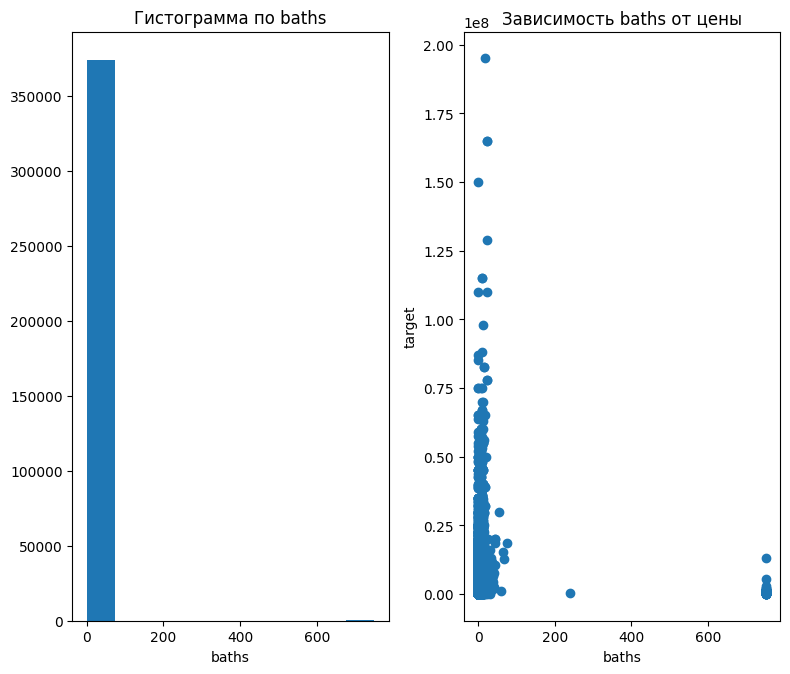

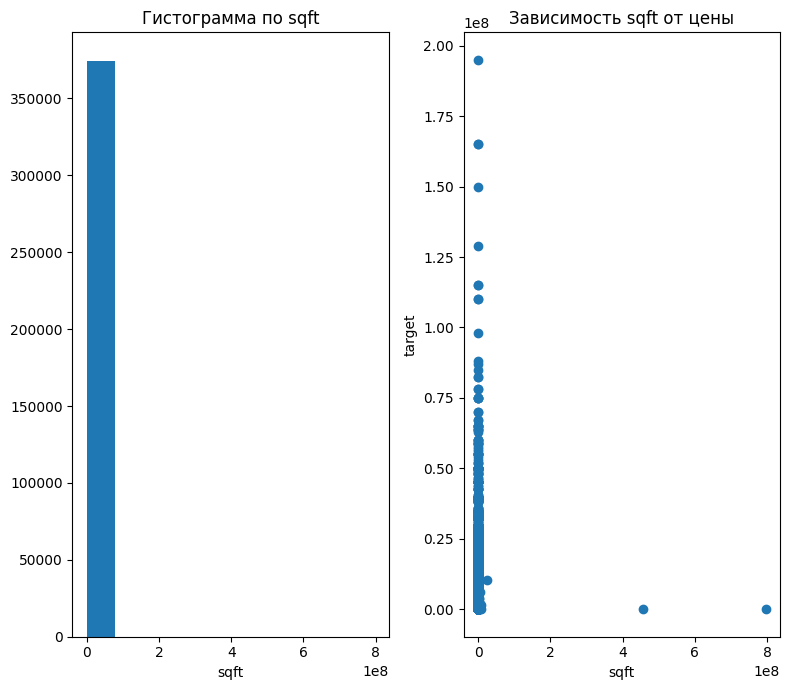

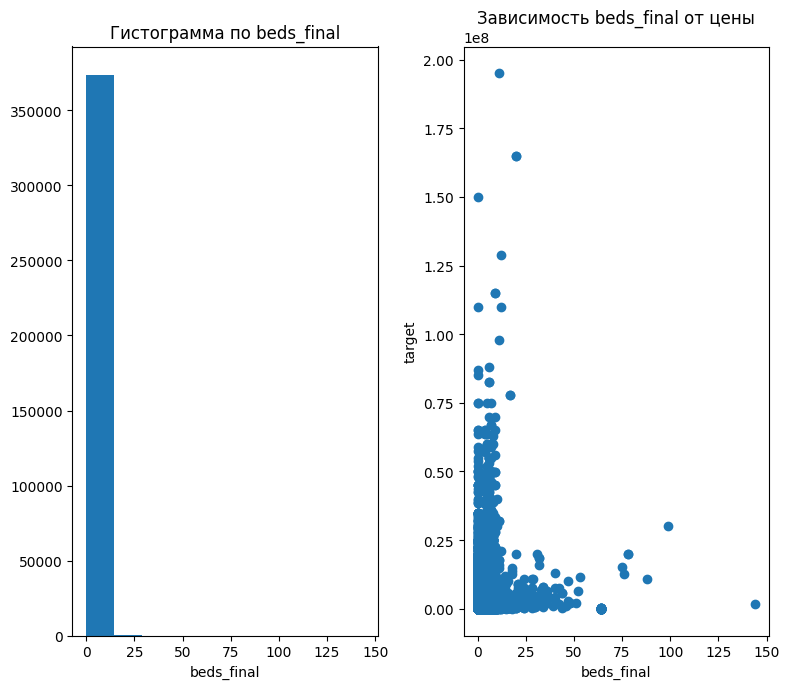

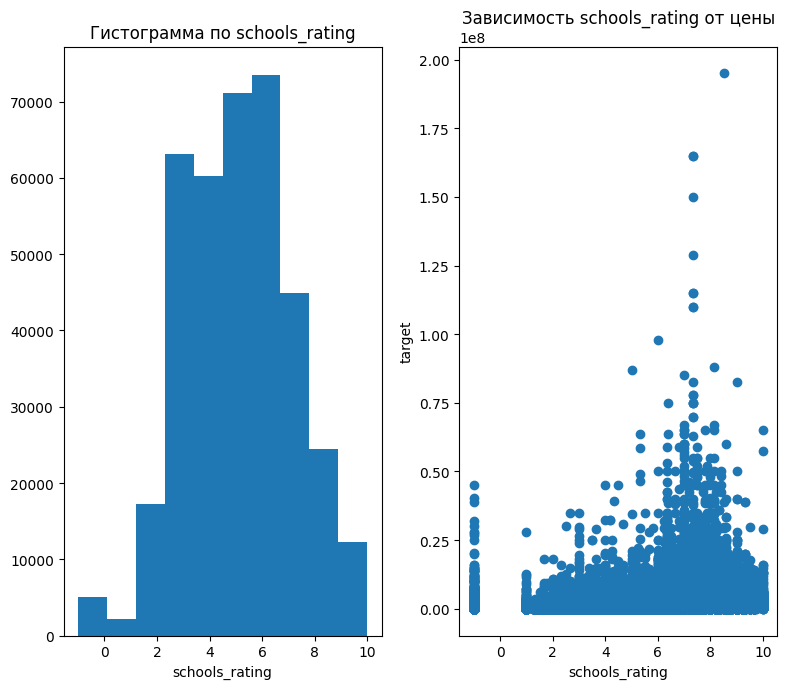

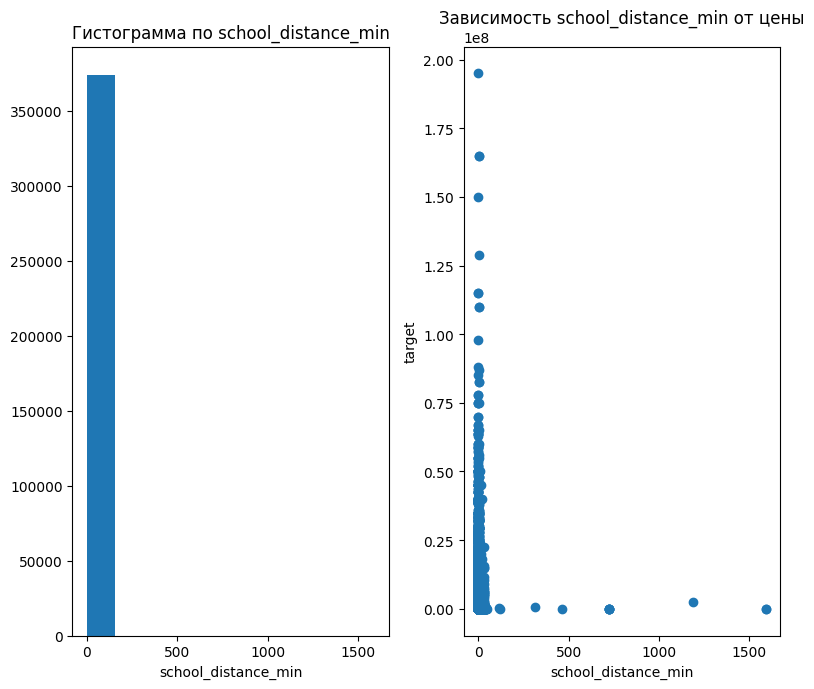

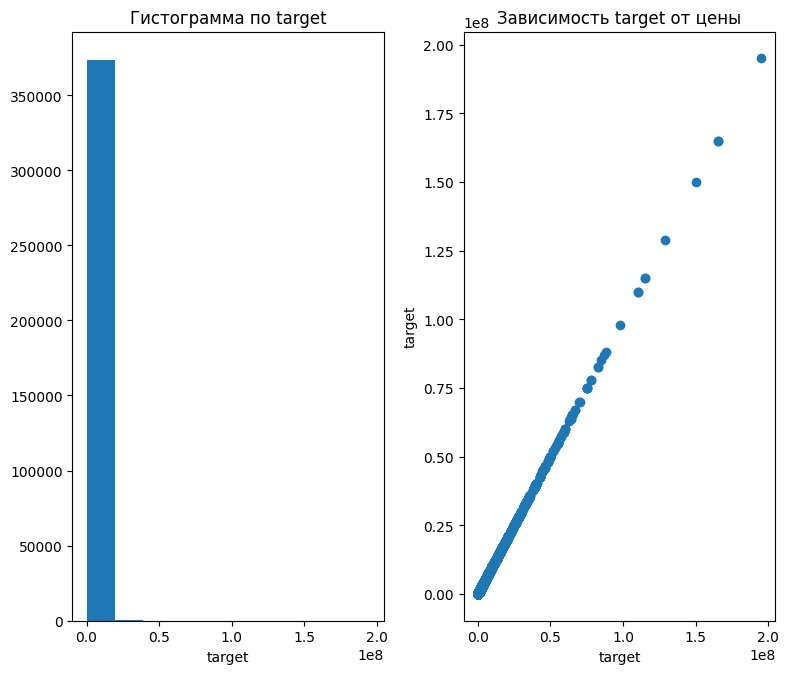

In [910]:
# создадим папку для хранения графиков
output_directory = 'images'
os.makedirs(output_directory, exist_ok=True)

# построим графики гистограмм и рассеивания для числовых признаков с таргетом
for feature in num_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7))
    
    ax1.hist(df[feature])
    ax1.set_xlabel(feature)
    ax1.set_title(f'Гистограмма по {feature}')
 
    ax2.scatter(data=df, x=feature, y='target')
    ax2.set_xlabel(feature)
    ax2.set_ylabel('target')
    ax2.set_title(f'Зависимость {feature} от цены')
    
    plt.tight_layout()

    # сохраним графики
    image_filename = os.path.join(output_directory, f'1_{feature}_plot.png')
    fig.savefig(image_filename)

По графикам видно, что:
1. По ванным - есть значения очень большие, в принципе такого количества ванных комнат не может быть, при этом цена за такие объекты очень низкая. Будем считать значения больше 200 - однозначными выбросами. Удалим их. Так же остается достаточно много объектов с большим количеством ванных комнат, при построении графика коробка с усами видно, что много выбросов больше 8-ми, найдем выбросы методом Тьюки и удалим их.<br>
2. По площади - есть объекты с огромной площадью, но с небольшой ценой, это явные выбросы, удалим их. Так же, мне кажется, что нулевая площадь будет ухудшать предсказания модели, потому что площадь является одним из ключевых показателей стоимости недвижимости, придется удалить объекты с нулевой площадью. Распределение признака не нормальное, сделаем очистку от выбросов по методу Тьюки с логарифмированием.<br>
3. По спальням - есть явные выбросы, так же применим метод Тьюки.<br>
4. График рейтинга распределен нормально. С тенденцией: при росте рейтинга, растет цена.<br>
5. По расстоянию до школы: применим метод Тьюки для удаления выбросов.<br><br>

Данные преобразвания реализованы ниже.

### baths

In [911]:
# удалим выбросы в столбце baths
condition_1 = df['baths'] > 200
df.drop(df[condition_1].index, inplace=True)

Добавим график коробку с усами, чтоб увидеть выбросы.

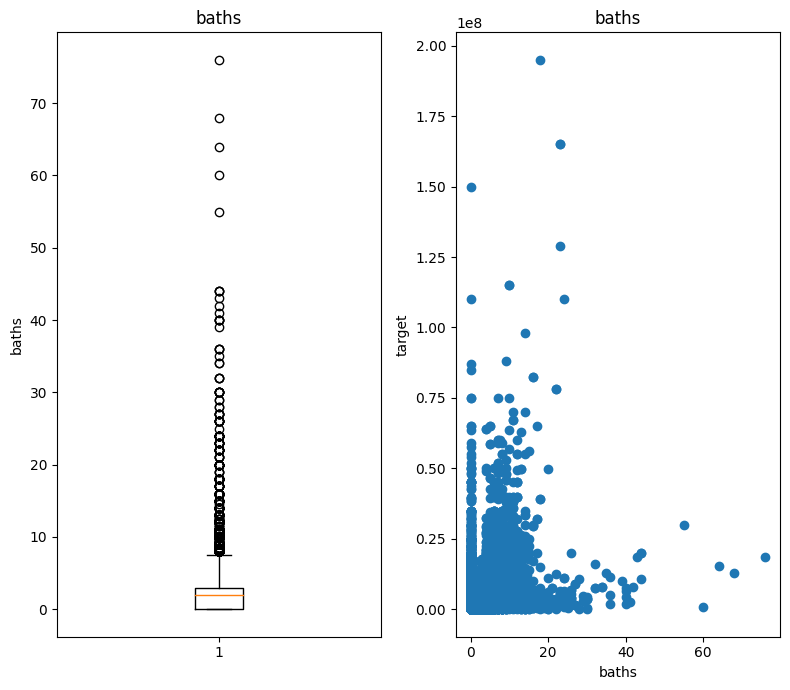

In [912]:
# график после удаления очевидных выбросов
num_features_1 = ['baths']
for feature in num_features_1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7))
    
    ax1.boxplot(df[feature])
    ax1.set_ylabel(feature)
    ax1.set_title(f'{feature}')
 
    ax2.scatter(data=df, x=feature, y='target')
    ax2.set_xlabel(feature)
    ax2.set_ylabel('target')
    ax2.set_title(f'{feature}')
    
    plt.tight_layout()
    
    # сохраним график
    image_filename = os.path.join(output_directory, f'2_{feature}_plot.png')
    fig.savefig(image_filename)

Воспользуемся методом межквартильного размаха для обнаружения и удаления выбросов.

In [913]:
# запускаем функцию для нахождения выбросов из отдельного файла
outliers1, cleaned1 = find_outliers_iqr(df, 'baths', left=2, right=2, log_scale=False)
print(f'Число выбросов по методу Тьюки: {outliers1.shape[0]}')
print(f'Результирующее число записей: {cleaned1.shape[0]}')

# удалим выбросы
df = df.drop(outliers1.index)

Число выбросов по методу Тьюки: 1022
Результирующее число записей: 372445


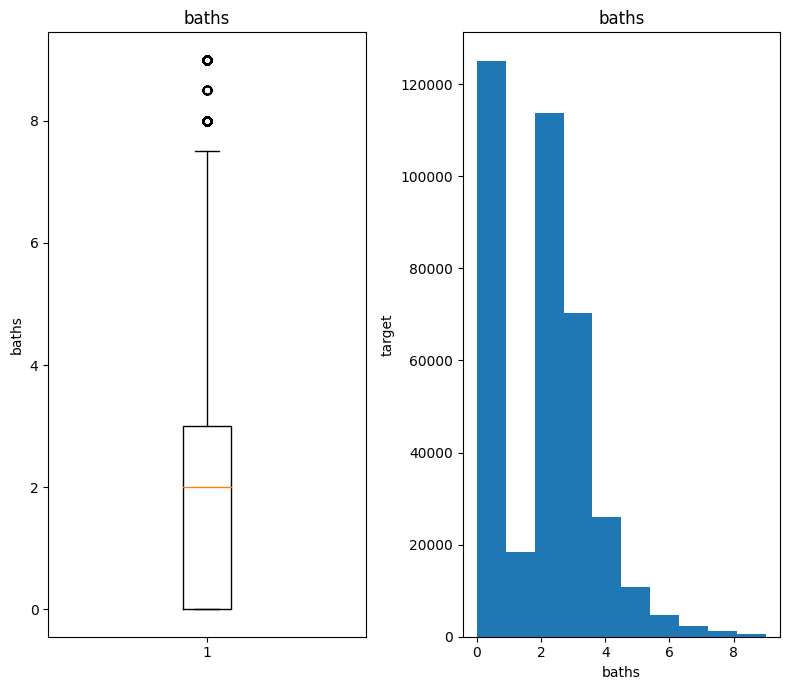

In [914]:
# график после удаления выбросов
num_features_1 = ['baths']
for feature in num_features_1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7))
    
    ax1.boxplot(df[feature])
    ax1.set_ylabel(feature)
    ax1.set_title(f'{feature}')
 
    ax2.hist(data=df, x='baths')
    ax2.set_xlabel(feature)
    ax2.set_ylabel('target')
    ax2.set_title(f'{feature}')
    
    plt.tight_layout()
    
    # сохраним график
    image_filename = os.path.join(output_directory, f'3_{feature}_plot.png')
    fig.savefig(image_filename)

### sqft

In [915]:
# удалим выбросы в столбце sqft
condition_2 = df['sqft'] > 400000000
display(df[condition_2])

,status,propertyType,street,baths,city,sqft,zipcode,state,target,private_pool_final,beds_final,schools_rating,school_distance_min,Year built,Remodeled year_final,Heating_final
62273,For sale,single family,1723 Pulte St,2.0,Cincinnati,795979430,45225,OH,27500,False,2.0,2.454545,0.78,1901,False,True
373597,Active,multi family,5382 S Dixie Hwy,0.0,Glendale,456602479,42740,KY,198000,False,0.0,6.333333,3.10,2012,False,True


In [916]:
# удалим выбросы в столбце sqft
df.drop(df[condition_2].index, inplace=True)

In [917]:
# посмотрим на столбцы с нулевой площадью
condition_3 = df['sqft'] == 0
df_3 = df[condition_3]
# проверим типы объектов недвижимости
df_3['propertyType'].unique()

# удалим строки с нулевой площадью
df.drop(df[condition_3].index, inplace=True)

Данные не являются нормально-распределенными, не является симметричным. Попробуем логарифмировать признак.

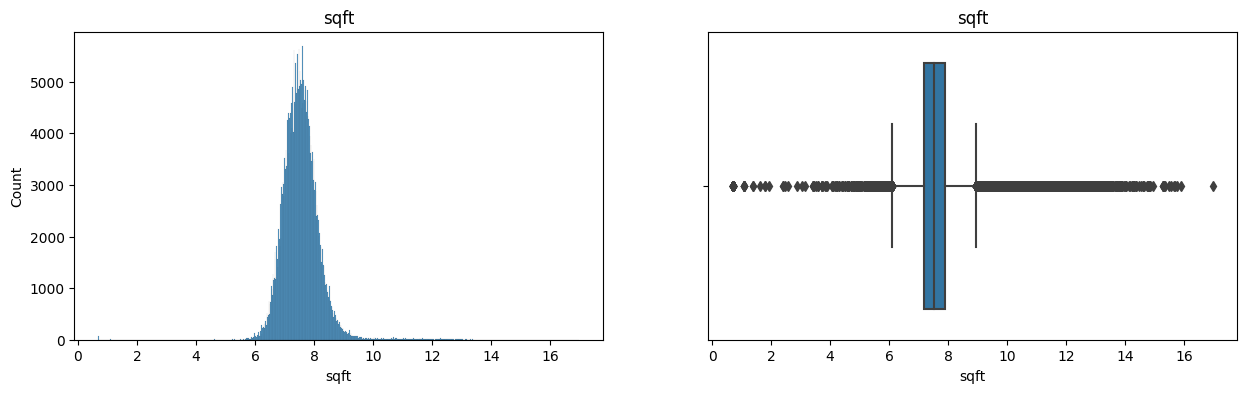

In [918]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x=np.log(df['sqft']+1), ax=axes[0])
histplot.set_title('sqft')
boxplot = sns.boxplot(data=df, x=np.log(df['sqft']+1), ax=axes[1])
boxplot.set_title('sqft')

# сохраним график
fig.savefig('images/2_sqft.png') 

С помощью логарифмирования удалось добиться симметрии в данных. Воспользуемся методом межквартильного размаха с предварительным логарифмированием и 2-мя размахами в левую и правую сторону распределения. 

Число выбросов по методу Тьюки: 4106
Результирующее число записей: 318983


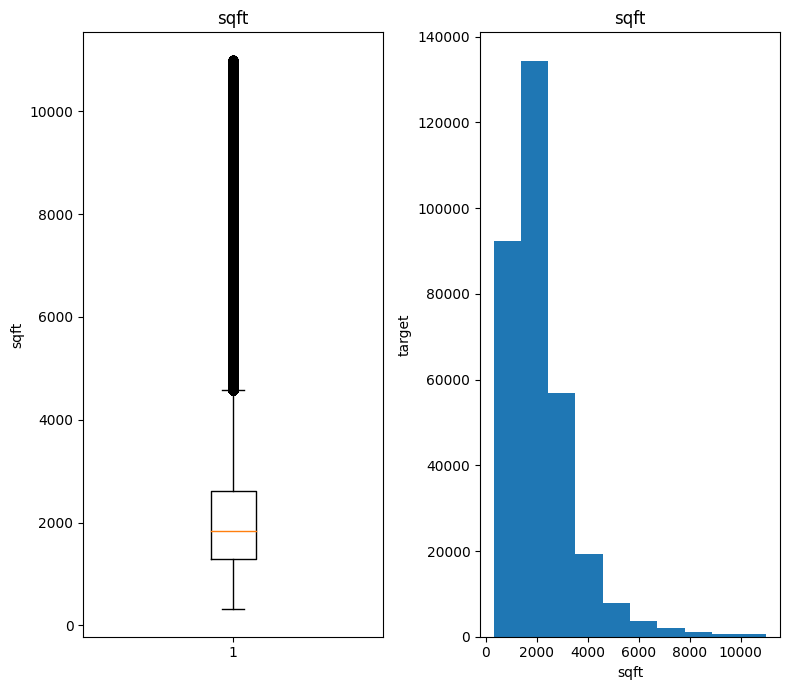

In [919]:

outliers2, cleaned2 = find_outliers_iqr(df, 'sqft', left=2, right=2, log_scale=True)
print(f'Число выбросов по методу Тьюки: {outliers2.shape[0]}')
print(f'Результирующее число записей: {cleaned2.shape[0]}')

# удалим выбросы
df = df.drop(outliers2.index)

# построим еще раз график
num_features_1 = ['sqft']
for feature in num_features_1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7))
    
    ax1.boxplot(df[feature])
    ax1.set_ylabel(feature)
    ax1.set_title(f'{feature}')
 
    ax2.hist(data=df, x='sqft')
    ax2.set_xlabel(feature)
    ax2.set_ylabel('target')
    ax2.set_title(f'{feature}')
    
    plt.tight_layout()
    
    # сохраним график
    image_filename = os.path.join(output_directory, f'4_{feature}_plot.png')
    fig.savefig(image_filename)

### school_distance_min

Число выбросов по методу Тьюки: 18994
Результирующее число записей: 299949


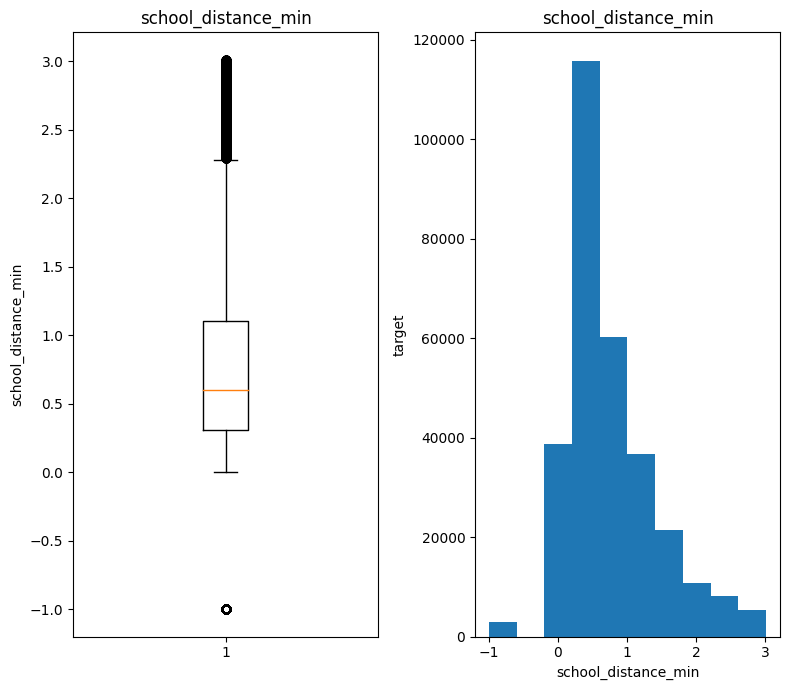

In [920]:
# запускаем функцию для нахождения выбросов из отдельного файла
outliers3, cleaned3 = find_outliers_iqr(df, 'school_distance_min', left=2, right=2, log_scale=False)
print(f'Число выбросов по методу Тьюки: {outliers3.shape[0]}')
print(f'Результирующее число записей: {cleaned3.shape[0]}')

# удалим выбросы
df = df.drop(outliers3.index)

# график после удаления выбросов
num_features_1 = ['school_distance_min']
for feature in num_features_1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7))
    
    ax1.boxplot(df[feature])
    ax1.set_ylabel(feature)
    ax1.set_title(f'{feature}')
 
    ax2.hist(data=df, x='school_distance_min')
    ax2.set_xlabel(feature)
    ax2.set_ylabel('target')
    ax2.set_title(f'{feature}')
    
    plt.tight_layout()
    
    # сохраним график
    image_filename = os.path.join(output_directory, f'2_{feature}_plot.png')
    fig.savefig(image_filename)

### beds_final

In [921]:
# посмотрим на столбцы с явными выбросами
condition_4 = df['beds_final'] > 100
df_4 = df[condition_4]
df_4

,status,propertyType,street,baths,city,sqft,zipcode,state,target,private_pool_final,beds_final,schools_rating,school_distance_min,Year built,Remodeled year_final,Heating_final


In [922]:
# удалим строки очевидным выбросом
df.drop(df[condition_4].index, inplace=True)

Воспользуемся методом межквартильного размаха для обнаружения и удаления выбросов.

In [923]:
# запускаем функцию для нахождения выбросов из отдельного файла
outliers4, cleaned4 = find_outliers_iqr(df, 'beds_final', left=2, right=2, log_scale=False)
print(f'Число выбросов по методу Тьюки: {outliers4.shape[0]}')
print(f'Результирующее число записей: {cleaned4.shape[0]}')

# удалим выбросы
df = df.drop(outliers4.index)

Число выбросов по методу Тьюки: 893
Результирующее число записей: 298102


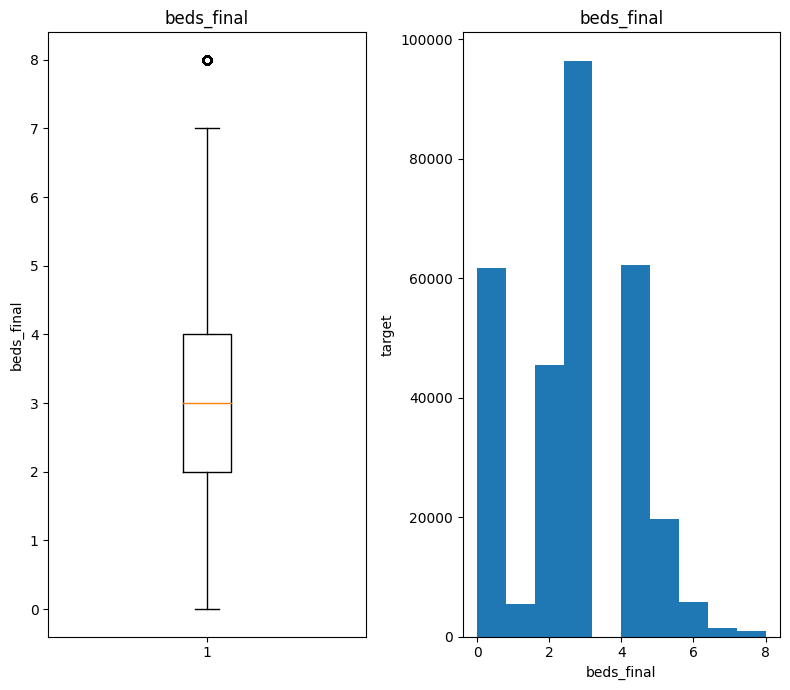

In [924]:
# график после удаления выбросов
num_features_1 = ['beds_final']
for feature in num_features_1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7))
    
    ax1.boxplot(df[feature])
    ax1.set_ylabel(feature)
    ax1.set_title(f'{feature}')
 
    ax2.hist(data=df, x='beds_final')
    ax2.set_xlabel(feature)
    ax2.set_ylabel('target')
    ax2.set_title(f'{feature}')
    
    plt.tight_layout()
    
    # сохраним график
    image_filename = os.path.join(output_directory, f'3_{feature}_plot.png')
    fig.savefig(image_filename)

### target

Есть данные со стронной ценой 1. Поставим ограничение на цену меньше 500 и удалим эти данные. 

In [925]:
# удалим экстремально маленькие значени цены
df = df.drop(df[df['target'] < 500].index)

In [926]:
# есть еще одна аномальная цена, слишком высокая цена, хоть и в Беверли Хиллз, с очень маленькой площадью
df[df['target'] > 100000000]

,status,propertyType,street,baths,city,sqft,zipcode,state,target,private_pool_final,beds_final,schools_rating,school_distance_min,Year built,Remodeled year_final,Heating_final
351518,For sale,land,1441 Angelo Dr,0.0,Beverly Hills,741,90210,CA,110000000,False,0.0,7.333333,1.97,2007,False,False


In [927]:
df = df.drop(df[df['target'] > 100000000].index)

Есть ощущение, что в целевом признаке все еще много "грязных" данных, слишком маленькая цена, при огромной площади и наоборот. Поэтому проверим target методом Тьюки на выбросы.

In [928]:
# запускаем функцию для нахождения выбросов из отдельного файла
outliers_tg, cleaned_tg = find_outliers_iqr(df, 'target', left=3, right=3, log_scale=False)
print(f'Число выбросов по методу Тьюки: {outliers_tg.shape[0]}')
print(f'Результирующее число записей: {cleaned_tg.shape[0]}')

# удалим выбросы
df = df.drop(outliers_tg.index)

Число выбросов по методу Тьюки: 15441
Результирующее число записей: 283642


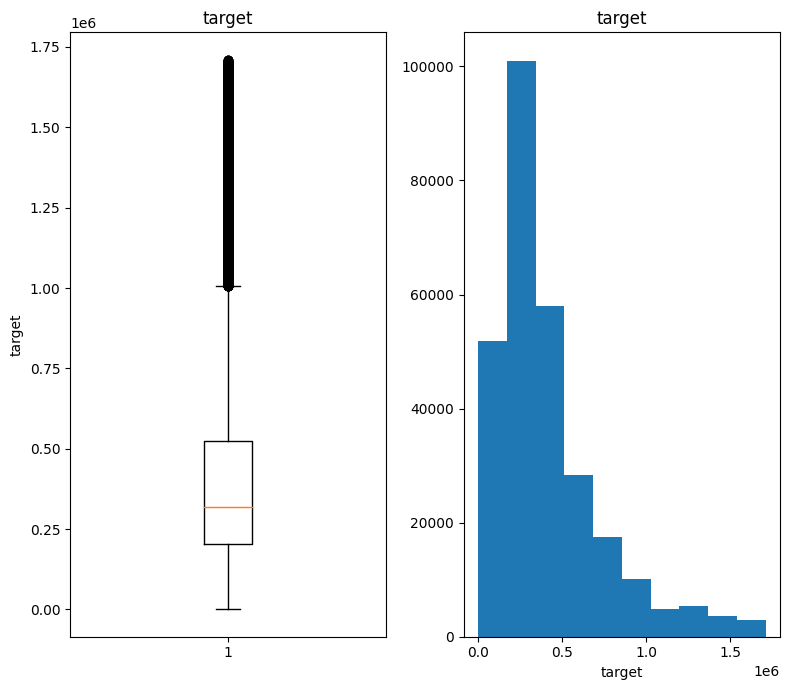

In [929]:
# график после удаления выбросов
num_features_1 = ['target']
for feature in num_features_1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 7))
    
    ax1.boxplot(df[feature])
    ax1.set_ylabel(feature)
    ax1.set_title(f'{feature}')
 
    ax2.hist(data=df, x='target')
    ax2.set_xlabel(feature)
    ax2.set_title(f'{feature}')
    
    plt.tight_layout()
    
    # сохраним график
    image_filename = os.path.join(output_directory, f'2_{feature}_plot.png')
    fig.savefig(image_filename)

### 2.2 Анализ категориальных признаков

In [930]:
# Составим список категоричальных признаков:
cat_features = ['status', 'propertyType', 'street', 'zipcode', 'state', 'city', 'Year built']
df.describe(include = 'object')

,status,propertyType,street,city,zipcode,state,Year built
count,283644,283644,283644,283644,283644,283644,283644
unique,13,11,252844,1641,3974,36,213
top,For sale,single family,Address Not Disclosed,Houston,33131,FL,2019
freq,160163,165861,552,21157,1391,82658,26824


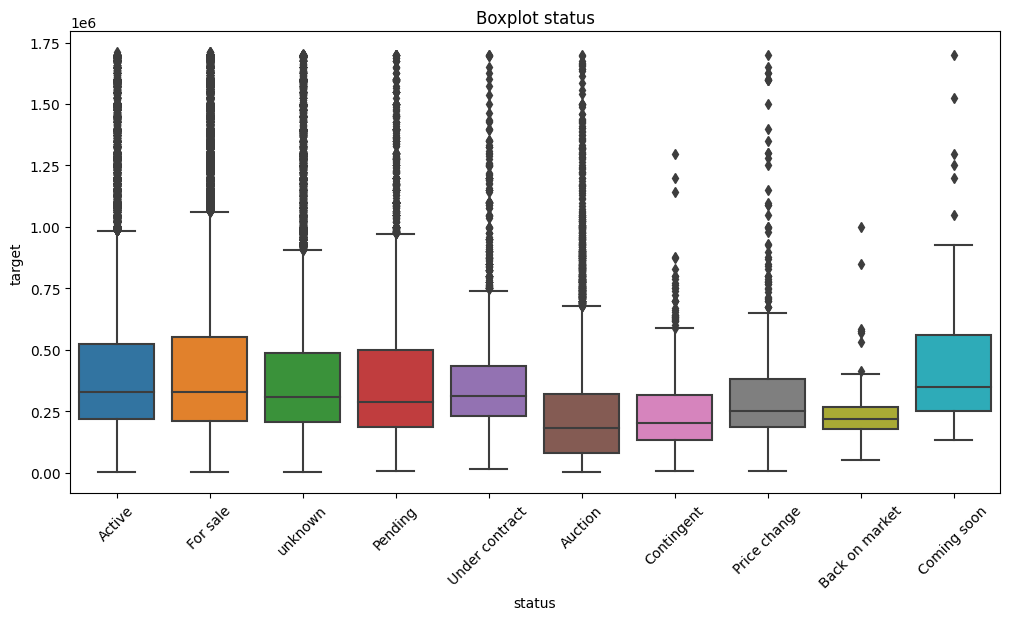

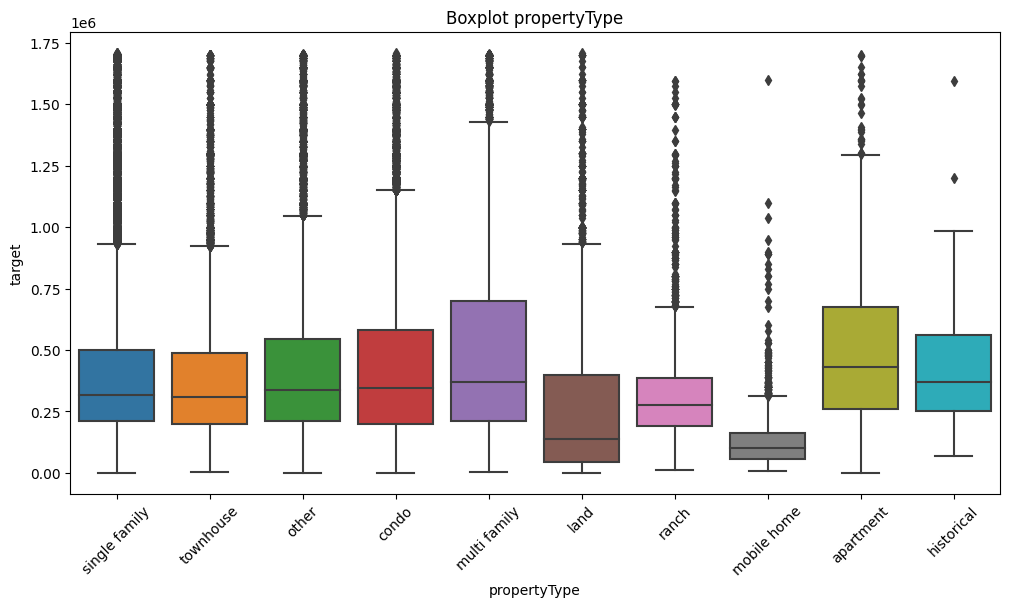

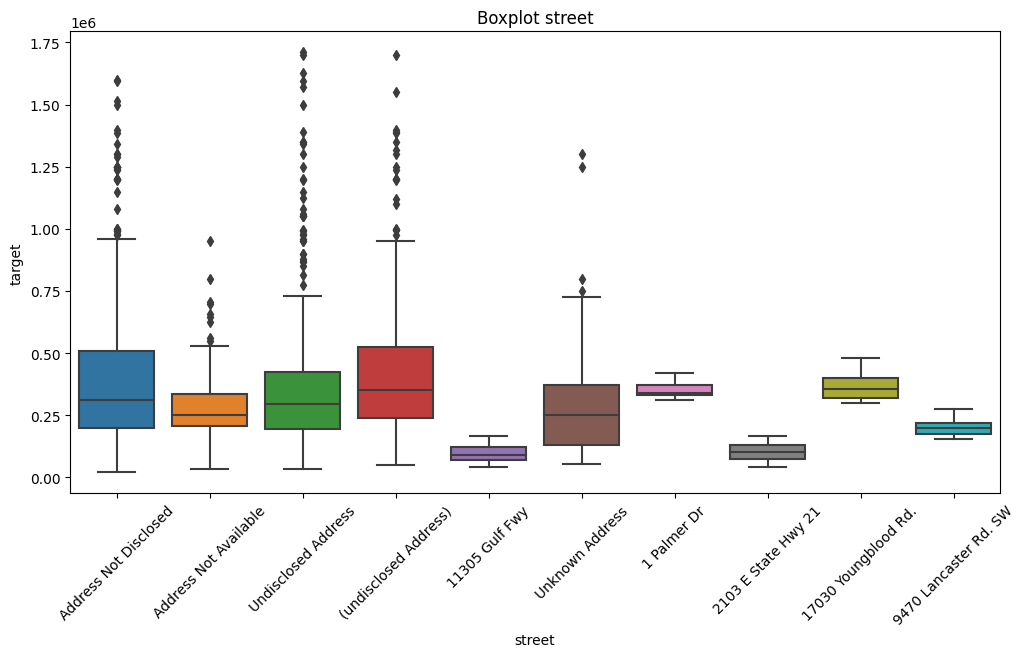

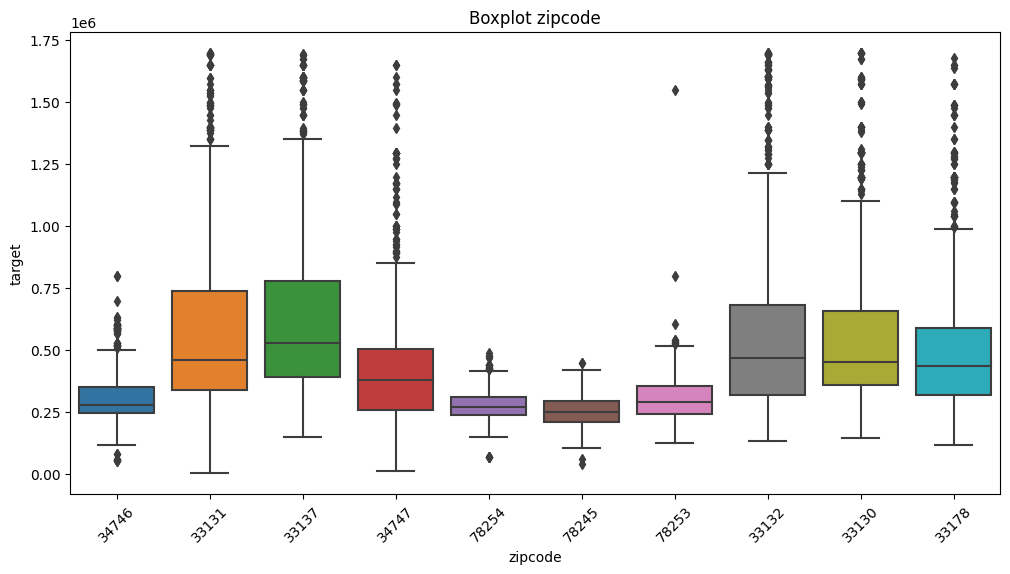

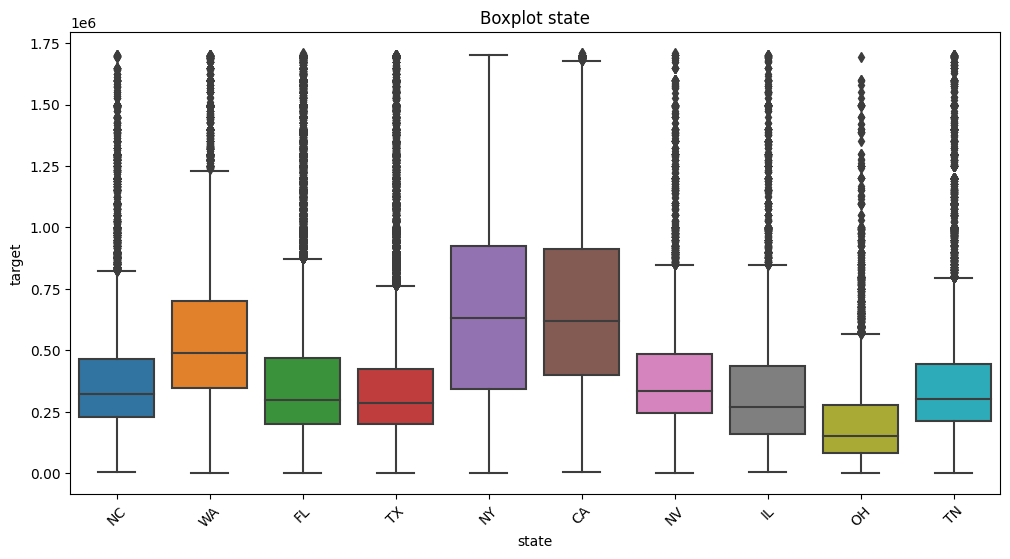

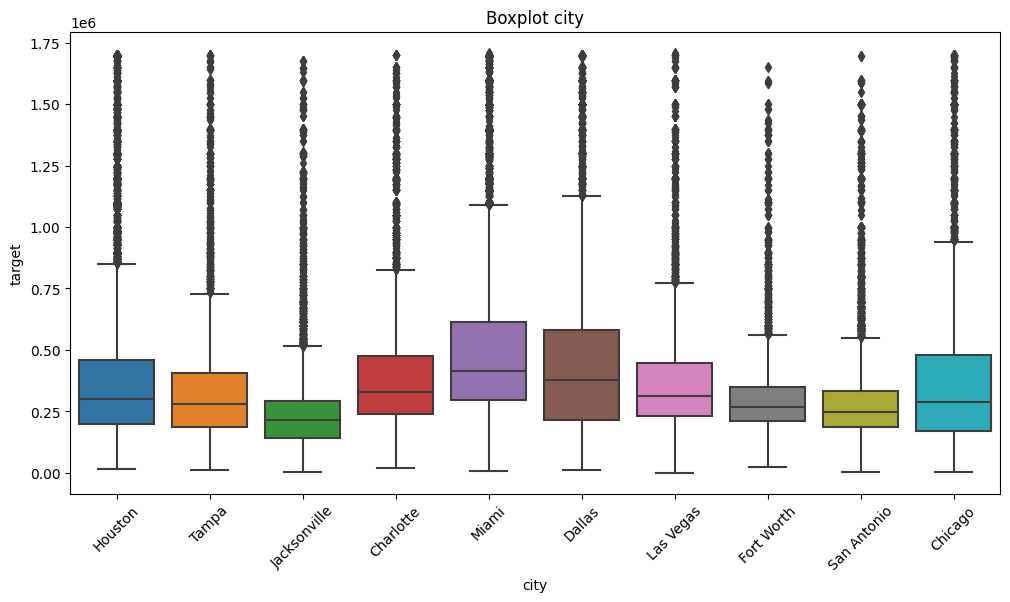

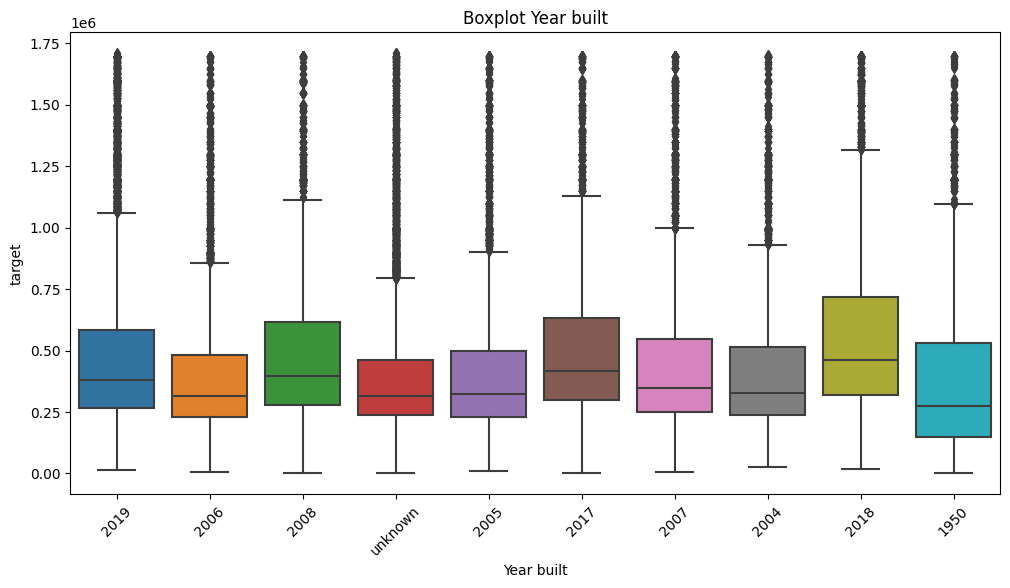

In [931]:
cat_features = ['status', 'propertyType', 'street', 'zipcode', 'state', 'city', 'Year built']
for cat in cat_features:
    fig, ax = plt.subplots(figsize = (12, 6))
    sns.boxplot(x=cat, y='target', data=df.loc[df.loc[:, cat].isin(df.loc[:, cat].value_counts().index[:10])], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot ' + cat)
    plt.show()
    
    # сохраняем графики
    image_filename = os.path.join(output_directory, f'5_{cat}_plot.png')
    fig.savefig(image_filename)

## 3. Проектирование признаков

### 3.1 Оценка мультиколлинеарности

C:\Users\sveta\AppData\Local\Temp\ipykernel_7584\3028576344.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True)


<AxesSubplot: >

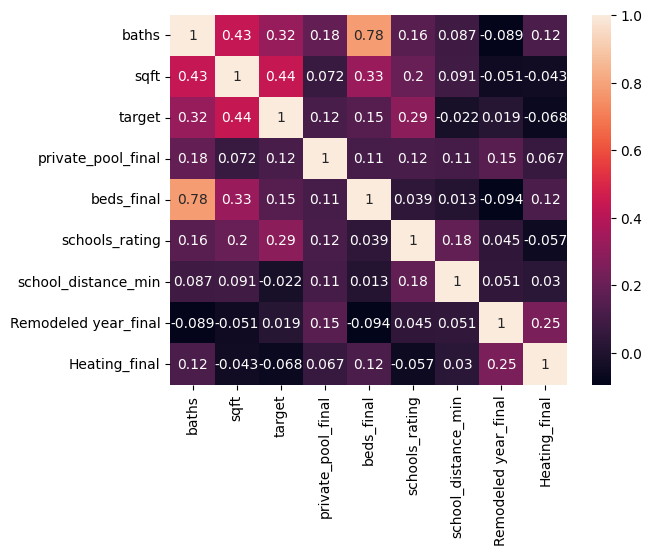

In [932]:
sns.heatmap(df.corr(), annot = True)

Видим сильную коллинеарность у двух признаков baths и beds_final. Думаю разумно оставить второй (количество спален в доме). Baths удаляем.

In [933]:
# Удаляем столбец baths
df = df.drop('baths', axis=1)

### 3.2. Нормализация

Так как у нас признаки разпределены ненормально, но сделана предварительноя очистка данных и удаление выбросов, то будем использовать MinMaxScaler нормализацию для числовых признаков.

In [934]:
# Создайте объект MinMaxScaler
#scaler = MinMaxScaler()

# Выберите столбцы для нормализации
#col_names = ['sqft', 'beds_final', 'schools_rating', 'school_distance_min', 'target']

# Произведите нормализацию и преобразуйте данные обратно в DataFrame
#df[col_names] = scaler.fit_transform(df[col_names])

In [935]:
# посмотрим по графикам как изменилось распределение признаков после нормализации
#fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
#ax1.set_title('После нормализации MinMaxScaler')

#sns.kdeplot(df['sqft'], ax=ax1, label='sqft')
#sns.kdeplot(df['beds_final'], ax=ax1, label='beds_final')
#sns.kdeplot(df['schools_rating'], ax=ax1, label='schools_rating')
#sns.kdeplot(df['school_distance_min'], ax=ax1, label='school_distance_min')
#sns.kdeplot(df['target'], ax=ax1, label='target')
#ax1.legend()
# сохраним график
#plt.savefig("images/6_MinMaxScaler.png")
#plt.show()


После нормализации признаки распределены более-менее нормально (за исключением beds_final), но несимметрично. Провела логарифмирование данных, но при этом распределение данных менялось кардинально. В итоге закомментировала блок с нормализацией, решила оставить логарифмирование данных.

In [936]:
# логорифмирование данных
for col in col_names:
        df[col] = df[col].apply(lambda x: abs(x))
        constant = 1e-6
        df[col] = np.log(df[col] + constant)
df

,status,propertyType,street,city,sqft,zipcode,state,target,private_pool_final,beds_final,schools_rating,school_distance_min,Year built,Remodeled year_final,Heating_final
0,Active,single family,240 Heather Ln,Southern Pines,7.972466,28387,NC,12.943237,False,1.386295,1.648659e+00,9.932521e-01,2019,False,True
1,For sale,single family,12911 E Heroy Ave,Spokane Valley,7.574045,99216,WA,12.644328,False,1.098613,1.386295e+00,9.951321e-03,2019,False,False
5,For sale,townhouse,1624 S Newkirk St,Philadelphia,6.799056,19145,PA,12.250090,False,0.693148,9.999995e-07,9.999995e-07,1920,False,True
6,Active,other,552 Casanova Ct,POINCIANA,7.317876,34759,FL,12.109011,False,-13.815511,8.472983e-01,-2.231423e-01,2006,True,True
9,unknown,single family,8612 Cedar Plains Ln,Houston,7.565275,77080,TX,12.650742,False,1.098613,1.098613e+00,-5.108240e-01,2019,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374244,unknown,single family,20800 NE 23rd Ave,Miami,8.298291,33180,FL,14.037854,True,1.609438,2.014903e+00,9.531109e-02,1990,True,True
374245,For sale,condo,3530 N Lake Shore Dr #4B,Chicago,7.600902,60657,IL,13.422466,False,1.098613,1.466337e+00,-9.162882e-01,1924,False,True
374246,For sale,single family,15509 Linden Blvd,Jamaica,7.049255,11434,NY,13.176852,False,1.098613,1.504078e+00,-7.339671e-01,1950,True,True
374247,unknown,other,7810 Pereida St,Houston,9.045348,77028,TX,10.448715,False,-13.815511,9.999995e-07,-6.931452e-01,unknown,False,False


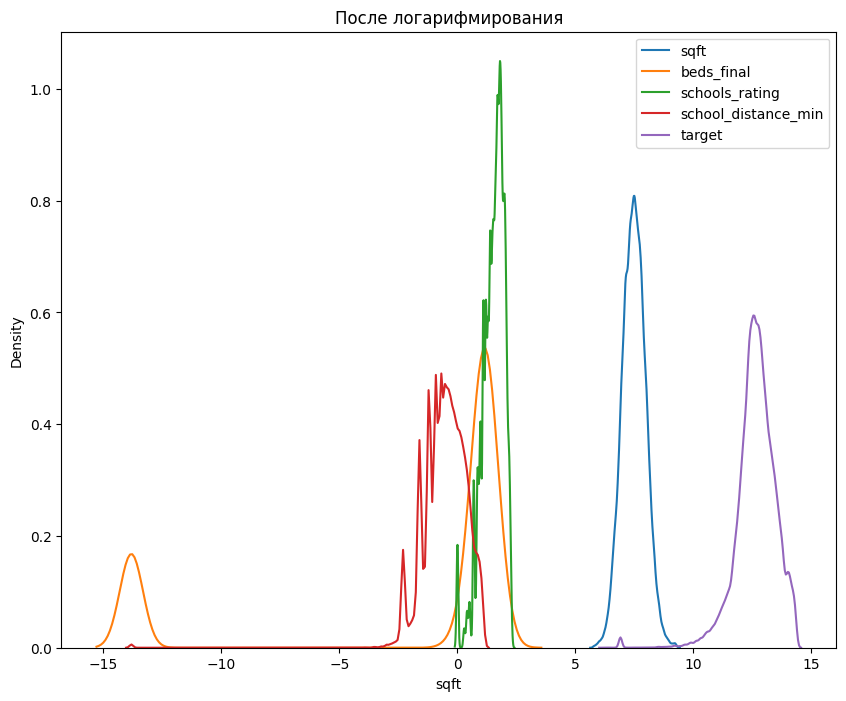

In [937]:
# посмотрим по графикам как изменилось распределение признаков после логарифмирования
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('После логарифмирования')

sns.kdeplot(df['sqft'], ax=ax1, label='sqft')
sns.kdeplot(df['beds_final'], ax=ax1, label='beds_final')
sns.kdeplot(df['schools_rating'], ax=ax1, label='schools_rating')
sns.kdeplot(df['school_distance_min'], ax=ax1, label='school_distance_min')
sns.kdeplot(df['target'], ax=ax1, label='target')
ax1.legend()
# сохраним график
plt.savefig("images/6_log.png")
plt.show()

## ДОПОЛНЕНИЕ ПОСЛЕ МОДЕЛИРОВАНИЯ

In [938]:
# сохраняем предобработанные данные в CSV-файл для работы в CatBoost без кодировки категориальных признаков
df.to_csv("data/cleaned_data_for_CatBoost.csv", index=False)

Продолжаем работу. Читаем файл с данными для дальнейшего кодирования.

In [939]:
df = pd.read_csv('data/cleaned_data_for_CatBoost.csv')
df.head()

,status,propertyType,street,city,sqft,zipcode,state,target,private_pool_final,beds_final,schools_rating,school_distance_min,Year built,Remodeled year_final,Heating_final
0,Active,single family,240 Heather Ln,Southern Pines,7.972466,28387,NC,12.943237,False,1.386295,1.648659e+00,9.932521e-01,2019,False,True
1,For sale,single family,12911 E Heroy Ave,Spokane Valley,7.574045,99216,WA,12.644328,False,1.098613,1.386295e+00,9.951321e-03,2019,False,False
2,For sale,townhouse,1624 S Newkirk St,Philadelphia,6.799056,19145,PA,12.250090,False,0.693148,9.999995e-07,9.999995e-07,1920,False,True
3,Active,other,552 Casanova Ct,POINCIANA,7.317876,34759,FL,12.109011,False,-13.815511,8.472983e-01,-2.231423e-01,2006,True,True
4,unknown,single family,8612 Cedar Plains Ln,Houston,7.565275,77080,TX,12.650742,False,1.098613,1.098613e+00,-5.108240e-01,2019,False,True


### 3.3. Кодирование признаков

In [940]:
df.describe(include = 'object')

,status,propertyType,street,city,state,Year built
count,283644,283644,283644,283644,283644,283644
unique,13,11,252844,1641,36,213
top,For sale,single family,Address Not Disclosed,Houston,FL,2019
freq,160163,165861,552,21157,82658,26824


Будем кодировать:
1. Однократное кодирование OneHotEncoder: status, propertyType
2. Признак street содержит слишком много уникальных значений, при этом при наличии информации по городу и индексу, получается, что он дублирует эту информацию, его удаляем.
3. Остальное кодируем LabelEncoder (city, zipcode, state, Year built)

In [941]:
# Удаляем столбец street
df = df.drop('street', axis=1)

In [942]:
# однократное кодирование для 2 х столбцов
df_encoded = pd.get_dummies(df, columns=['status', 'propertyType'])
df_encoded.head()

,city,sqft,zipcode,state,target,private_pool_final,beds_final,schools_rating,school_distance_min,Year built,...,propertyType_condo,propertyType_historical,propertyType_land,propertyType_mobile home,propertyType_multi family,propertyType_other,propertyType_ranch,propertyType_single family,propertyType_townhouse,propertyType_unknown
0,Southern Pines,7.972466,28387,NC,12.943237,False,1.386295,1.648659e+00,9.932521e-01,2019,...,0,0,0,0,0,0,0,1,0,0
1,Spokane Valley,7.574045,99216,WA,12.644328,False,1.098613,1.386295e+00,9.951321e-03,2019,...,0,0,0,0,0,0,0,1,0,0
2,Philadelphia,6.799056,19145,PA,12.250090,False,0.693148,9.999995e-07,9.999995e-07,1920,...,0,0,0,0,0,0,0,0,1,0
3,POINCIANA,7.317876,34759,FL,12.109011,False,-13.815511,8.472983e-01,-2.231423e-01,2006,...,0,0,0,0,0,1,0,0,0,0
4,Houston,7.565275,77080,TX,12.650742,False,1.098613,1.098613e+00,-5.108240e-01,2019,...,0,0,0,0,0,0,0,1,0,0


In [943]:
# кодируем оставшиеся признаки
state_le = LabelEncoder()
state_label = state_le.fit_transform(df_encoded['state'])

yearb_le = LabelEncoder()
yearb_label = yearb_le.fit_transform(df_encoded['Year built'])

city_le = LabelEncoder()
city_label = city_le.fit_transform(df_encoded['city'])

zipcode_le = LabelEncoder()
zipcode_label = zipcode_le.fit_transform(df_encoded['zipcode'])

# добавляем закодированные столбцы в дата фрейм
df_encoded['state_label'] = state_label
df_encoded['year_label'] = yearb_label
df_encoded['city_label'] = city_label
df_encoded['zipcode_label'] = zipcode_label

# удаляем обработанные столбцы
df_encoded.drop(['state', 'city', 'zipcode','Year built'], axis=1, inplace=True)

In [944]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283644 entries, 0 to 283643
Data columns (total 36 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   sqft                        283644 non-null  float64
 1   target                      283644 non-null  float64
 2   private_pool_final          283644 non-null  bool   
 3   beds_final                  283644 non-null  float64
 4   schools_rating              283644 non-null  float64
 5   school_distance_min         283644 non-null  float64
 6   Remodeled year_final        283644 non-null  bool   
 7   Heating_final               283644 non-null  bool   
 8   status_Active               283644 non-null  uint8  
 9   status_Auction              283644 non-null  uint8  
 10  status_Back on market       283644 non-null  uint8  
 11  status_Closed               283644 non-null  uint8  
 12  status_Coming soon          283644 non-null  uint8  
 13  status_Conting

In [945]:
# сохраняем предобработанные данные в CSV-файл для упрощения дальнейшей работы
df_encoded.to_csv("data/cleaned_data_for_model.csv", index=False)

## *Выводы 2 и 3 частей работы:*
- изучили взаимосвязи между признаками и таргетом
- изучили числовые признаки, нашли и удалили выбросы методом Тьюки
- изучили категориальные признаки
- проверили признаки на мультиколлинеарность
- провели логарифмирование признаков
- провели кодирование признаков
- сохранили файл в CSV-файл для упрощения дальнейшей работы при подборе модели и предсказании